In [1]:
import numpy as np
import tensorflow as tf
import random
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import sys
from datetime import datetime

In [2]:
# Work-around for loading a module from a parent folder in Jupyter/Notebooks
parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from modules.autoencoders import VanillaAutoencoder, ConvolutedAutoencoder, VariationalAutoencoder, ConditionedVariationalAutoencoder

In [3]:
# Caricamento dei dati
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Caricamento dei dati
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=-1, as_supervised=True)
x_train, y_train = tfds.as_numpy(train_ds)
x_test, y_test = tfds.as_numpy(test_ds)
#x_train = x_train[:,:,:,0]
#x_test = x_test[:,:,:,0]

In [5]:
# Normalizzazione dei pixel a [0, 1]
norm_x_train = x_train.astype('float32') / 255.
norm_x_test = x_test.astype('float32') / 255.

In [6]:
classes = np.unique(y_train)
n_classes = len(classes)

In [7]:
#model_name = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "20250320_175412"
model_path = os.path.join("..", "models")

# Dataset Analisys

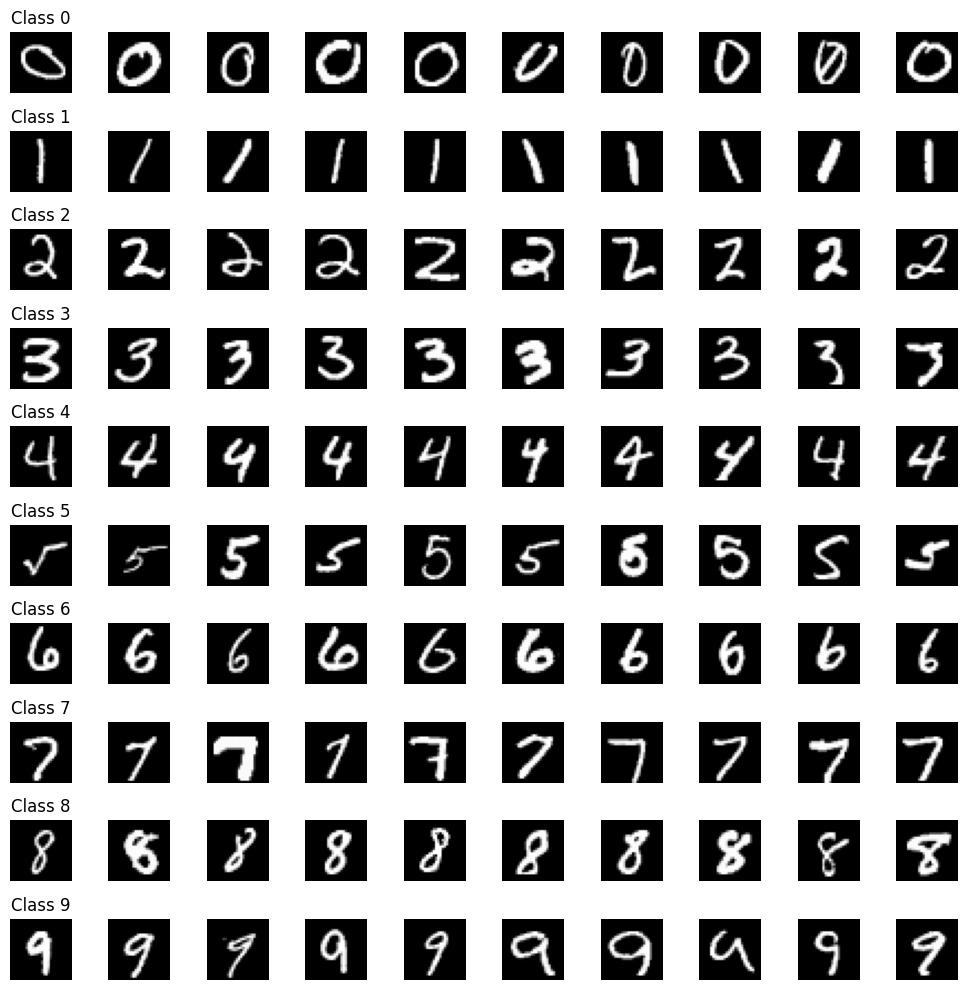

In [8]:
# Troviamo le classi presenti (da 0 a 9)
samples_per_class = 10  # Numero di esempi per classe da visualizzare

# Creiamo una griglia di subplot: righe = n_classes, colonne = samples_per_class
fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 1, n_classes * 1))

for i, cls in enumerate(classes):
    # Trova gli indici degli esempi per la classe corrente
    idxs = np.where(y_train == cls)[0]    
    # Mostra l'etichetta sulla prima colonna di ogni riga
    axes[i, 0].set_title(f"Class {cls}")
    j=0    
    # Seleziona randomicamente samples_per_class indici tra quelli della classe corrente
    for idx in random.sample(list(idxs), samples_per_class):
        # Seleziona l'immagine
        img = x_train[idx]
        # Visualizza l'immagine
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        j=j+1

plt.tight_layout()
plt.show()

# Utils

In [9]:
def plot_img(immagine, titolo="Sampled Image", figsize=(4,4)):
    """
    Plotta una immagine, convertendola se necessario da vettoriale (784,) a matrice (28,28).

    Parametri:
    - immagine: numpy array rappresentante l'immagine (forma (784,) o (28,28))
    - titolo: titolo da visualizzare sul plot
    """
    # Se l'immagine è un vettore piatto, la rimodelliamo in 28x28
    if immagine.ndim == 1 or (immagine.ndim == 2 and immagine.shape[0] * immagine.shape[1] == 784):
        immagine = immagine.reshape(28, 28)

    plt.figure(figsize=figsize)
    plt.imshow(immagine, cmap='gray')
    plt.title(titolo)
    plt.axis('off')
    plt.show()

In [10]:
def plot_encoding_tsne(encoder, data, labels, sample_size=None, perplexity=30, random_state=42, title="t-SNE projection of the latent space", figsize=(6, 4)):
    """
    Calcola l'encoding dei dati con il modello encoder e proietta le rappresentazioni latenti in 2D
    utilizzando t-SNE. I punti sono colorati in modo discreto in base alle etichette (classi).

    Parametri:
    - encoder: modello Keras per ottenere l'encoding.
    - dati: array dei dati in input (es. immagini).
    - labels: array delle etichette corrispondenti.
    - sample_size: (opzionale) numero di campioni da utilizzare per t-SNE (se None usa tutti i dati).
    - perplexity: parametro perplexity per t-SNE.
    - random_state: seme per la riproducibilità.
    """
    # Se sample_size è definito e minore del numero totale di dati, campiona casualmente
    if sample_size is not None and sample_size < len(data):
        idx = np.random.choice(len(data), size=sample_size, replace=False)
        data = data[idx]
        labels = labels[idx]

    # Calcola l'encoding dei dati
    _predicted_ = encoder.predict(data)
    if type(_predicted_) == list:
        latent = _predicted_[0]
    else:
        latent = _predicted_

    # Riduci a 2 dimensioni con t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    latent_2d = tsne.fit_transform(latent)

    # Ottieni le etichette uniche
    unique_labels = np.unique(labels)
    # Se ci sono al massimo 10 classi, usiamo 'tab10', altrimenti 'tab20'
    if len(unique_labels) <= 10:
        cmap = plt.get_cmap('tab10', len(unique_labels))
    else:
        cmap = plt.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=figsize)
    # Plot separato per ogni classe con colori distinti
    for i, ul in enumerate(unique_labels):
        idx = labels == ul
        plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1],
                    color=cmap(i), label=str(ul), s=5)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title='Classes')
    plt.show()


# Vanilla Autoencoder

In [11]:
flatten_x_train = norm_x_train.reshape((len(norm_x_train), -1))
flatten_x_test = norm_x_test.reshape((len(norm_x_test), -1))

In [12]:
input_dim = flatten_x_train.shape[1]
neurons=(128, 64, 32)
activations=('relu', 'relu', 'relu')
latent_space_dim=2

vannilla_model_type = VanillaAutoencoder.__name__

vanilla_model_params_path = os.path.join(model_path, f"{vannilla_model_type}_{model_name}.parameters.pkl")
vanilla_model_weights_path = os.path.join(model_path, f"{vannilla_model_type}_{model_name}.weights.h5")
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    vanilla_model = VanillaAutoencoder(input_dim=input_dim, neurons=neurons, activations=activations, latent_space_dim=latent_space_dim, model_name=model_name)
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.0001)
    vanilla_model.compile(optimizer=optimizer, loss='mse')
else:
    vanilla_model = VanillaAutoencoder.load(model_path, model_name)

vanilla_model.print_summaries()

Model: "20250320_175412"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ (None, 2)                   │         110,882 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 784)                 │         111,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ VanillaAutoencoder_20250320_175412_… │ (None, 784)                 │         222,546 │
│ (Functional)                         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,546 (869.32 KB)

 Trainable params: 222,546 (869.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer_1 (Dense)              │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer_2 (Dense)              │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer_3 (Dense)              │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,882 (433.13 KB)

 Trainable params: 110,882 (433.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_1 (Dense)              │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_2 (Dense)              │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer_3 (Dense)              │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,664 (436.19 KB)

 Trainable params: 111,664 (436.19 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    history = vanilla_model.train(
                flatten_x_train, 
                flatten_x_test,
                epochs=10,
                batch_size=512,
                shuffle=True)
else:
    history = vanilla_model.get_training_history()

In [14]:
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    vanilla_model.save(model_path)

In [15]:
vanilla_encoder = vanilla_model.get_encoder()
vanilla_decoder = vanilla_model.get_decoder()
vanilla_autoencoder = vanilla_model

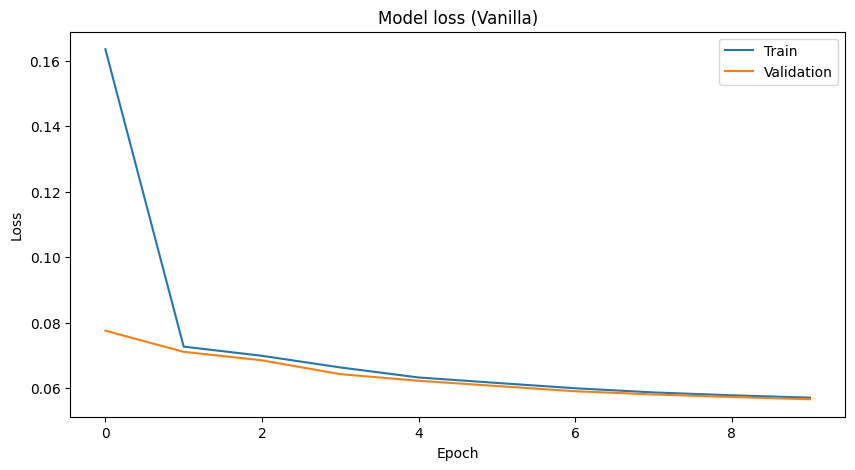

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Vanilla)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
latent_reps = vanilla_encoder.predict(flatten_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [18]:
latent_mean = np.mean(latent_reps, axis=0)
latent_std = np.std(latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


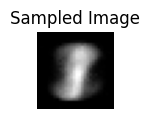

In [19]:
encoded_img = np.random.normal(loc=latent_mean, scale=latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
decoded_img = vanilla_decoder.predict(encoded_img)
# Genera una nuova immagine
plot_img(decoded_img, figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


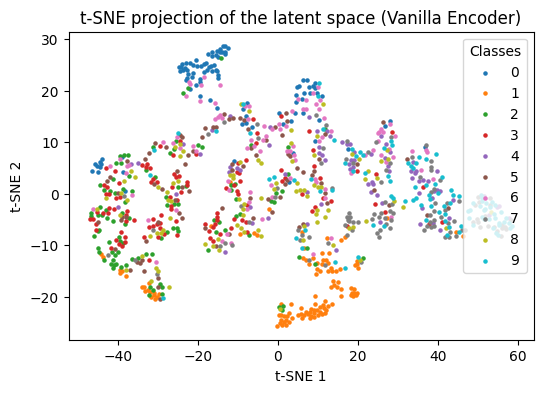

In [20]:
plot_encoding_tsne(vanilla_encoder, flatten_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Vanilla Encoder)")

# Convoluted Autoencoder

In [21]:
conv_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
conv_filters=(32, 64, 64, 64)
conv_activations=('relu', 'relu', 'relu', 'relu')
conv_kernels=(3, 3, 3, 3)
conv_strides=(1, 2, 2, 1)
conv_latent_space_dim=2

conv_model_type = ConvolutedAutoencoder.__name__

conv_model_params_path = os.path.join(model_path, f"{conv_model_type}_{model_name}.parameters.pkl")
conv_model_weights_path = os.path.join(model_path, f"{conv_model_type}_{model_name}.weights.h5")
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_model = ConvolutedAutoencoder(
        input_shape=conv_input_shape, 
        filters=conv_filters, 
        kernels=conv_kernels, 
        strides=conv_strides, 
        activations=conv_activations,
        latent_space_dim=conv_latent_space_dim,
        model_name=model_name
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.0001)
    conv_model.compile(optimizer=optimizer, loss='mse')
else:
    conv_model = ConvolutedAutoencoder.load(model_path, model_name)

conv_model.print_summaries()

Model: "20250320_175412"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ (None, 2)                   │          99,842 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         121,537 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ConvolutedAutoencoder_20250320_1754… │ (None, 28, 28, 1)           │         221,379 │
│ (Functional)                         │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_1 (Conv2D)        │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_1 (Activation)          │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_1 (BatchNormalization)    │ (None, 28, 28, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_2 (Conv2D)        │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_2 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_3 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_3 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_3 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_conv_layer_4 (Conv2D)        │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_relu_4 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_bn_4 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           6,274 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense (Dense)                │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_1       │ (None, 7, 7, 64)            │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_1 (Activation)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_1 (BatchNormalization)    │ (None, 7, 7, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_2       │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_2 (Activation)          │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_2 (BatchNormalization)    │ (None, 14, 14, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_3       │ (None, 28, 28, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_relu_3 (Activation)          │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_bn_3 (BatchNormalization)    │ (None, 28, 28, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_transpose_layer_4       │ (None, 28, 28, 1)           │             577 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sigmoid_layer (Activation)           │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
#tf.config.run_functions_eagerly(False)
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_history = conv_model.train(
                norm_x_train, 
                norm_x_test,
                epochs=10,
                batch_size=512,
                shuffle=True
            )
else:
    conv_history = conv_model.get_training_history()

In [23]:
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_model.save(model_path)

In [24]:
conv_encoder = conv_model.get_encoder()
conv_decoder = conv_model.get_decoder()
conv_autoencoder = conv_model

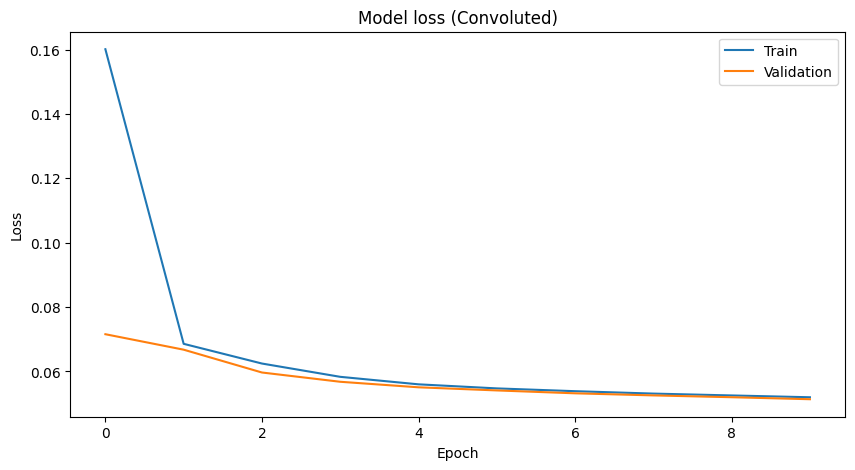

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model loss (Convoluted)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [26]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
conv_latent_reps = conv_encoder.predict(norm_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


In [27]:
conv_latent_mean = np.mean(conv_latent_reps, axis=0)
conv_latent_std = np.std(conv_latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


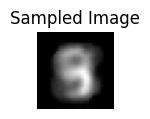

In [28]:
conv_encoded_img = np.random.normal(loc=conv_latent_mean, scale=conv_latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
conv_decoded_img = conv_decoder.predict(conv_encoded_img)
# Genera una nuova immagine
plot_img(conv_decoded_img[0], figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


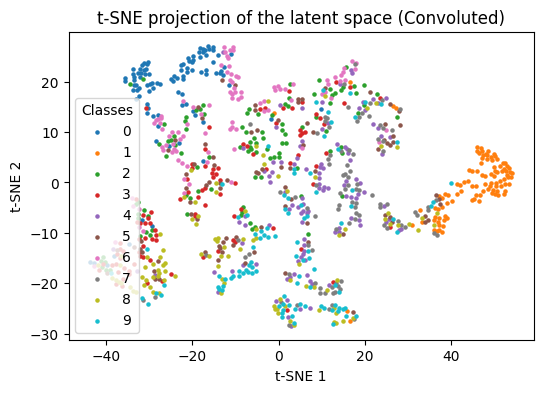

In [29]:
plot_encoding_tsne(conv_encoder, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Convoluted)")

# Variational Autoencoder

## Loss Function for Variational Autoencoders

$Loss = \alpha \cdot RMSE + KL$

* $RMSE$  
Root mean squared error. It's the Reconstruction error
* $\alpha$ 
Reconstruction loss weight
* $KL$  
Kullback-Leibler divergence. It measures the _difference_ between a multivariate normal distribution and a multivariate standard normal distribution.  
A standard normal distribution is a normal distribution with mean ($\mu$) equal to 0 and standard deviation ($\sigma$) equal to 1

Kullback-Leibler divergence (Closed-form)  
$D_{KL} (N(\mu,\sigma) || N(0,1))= \frac{1}{2} \sum \left(1+\log(\sigma^2)-\mu^2-\sigma^2\right)$

In [30]:
vae_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
vae_filters=(32, 64, 64, 64)
vae_activations=('relu', 'relu', 'relu', 'relu')
vae_kernels=(3, 3, 3, 3)
vae_strides=(1, 2, 2, 1)
vae_latent_space_dim=2

vae_model_type = VariationalAutoencoder.__name__

vae_model_params_path = os.path.join(model_path, f"{vae_model_type}_{model_name}.parameters.pkl")
vae_model_weights_path = os.path.join(model_path, f"{vae_model_type}_{model_name}.weights.h5")
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_model = VariationalAutoencoder(
        input_shape=vae_input_shape, 
        filters=vae_filters, 
        kernels=vae_kernels, 
        strides=vae_strides, 
        activations=vae_activations,
        latent_space_dim=vae_latent_space_dim,
        model_name=model_name,
        reconstruction_loss_weight=1
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.001)
    vae_model.compile(optimizer=optimizer)
else:
    vae_model = VariationalAutoencoder.load(model_path, model_name)

#vae_model.print_summaries()

In [31]:
#tf.config.run_functions_eagerly(False)
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_history = vae_model.train(
                norm_x_train, 
                norm_x_test,
                epochs=20,
                batch_size=512,
                shuffle=True
            )
else:
    vae_history = vae_model.get_training_history()

In [32]:
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_model.save(model_path)

In [33]:
vae_encoder = vae_model.get_encoder()
vae_decoder = vae_model.get_decoder()
vae_autoencoder = vae_model

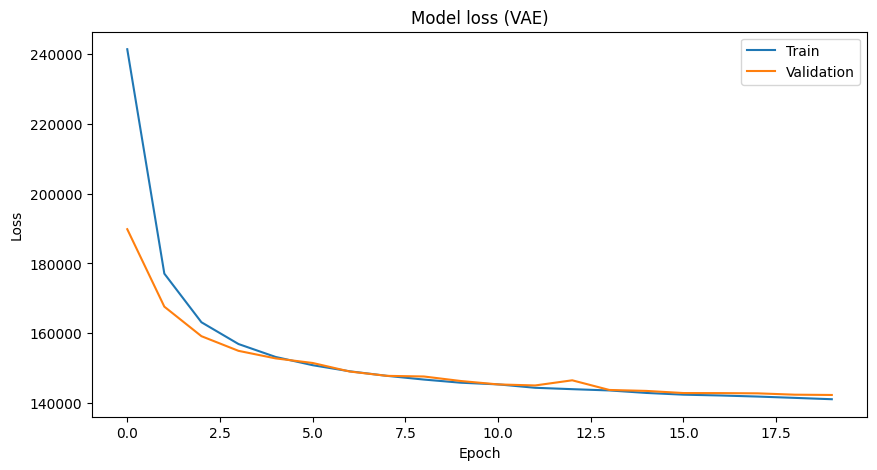

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('Model loss (VAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [35]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
vae_latent_reps, _, _ = vae_encoder.predict(norm_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


In [36]:
vae_latent_mean = np.mean(vae_latent_reps, axis=0)
vae_latent_std = np.std(vae_latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


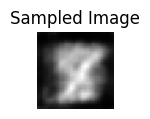

In [37]:
vae_encoded_img = np.random.normal(loc=vae_latent_mean, scale=vae_latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
vae_decoded_img = vae_decoder.predict(vae_encoded_img)
# Genera una nuova immagine
plot_img(vae_decoded_img[0], figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


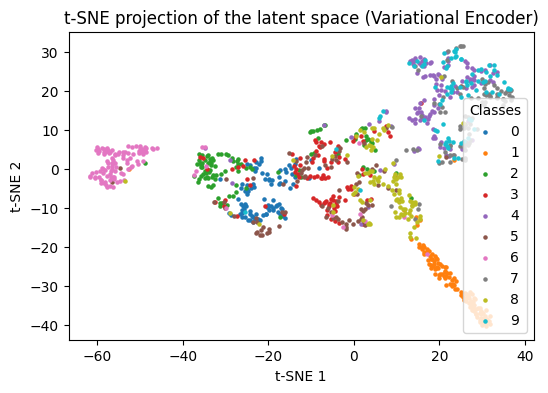

In [38]:
plot_encoding_tsne(vae_encoder, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Variational Encoder)")

# Conditioned Variational Autoencoder

In [39]:
cvae_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
cvae_innput_labels_dim = n_classes
cvae_filters=(32, 64, 64, 64)
cvae_activations=('relu', 'relu', 'relu', 'relu')
cvae_kernels=(3, 3, 3, 3)
cvae_strides=(1, 2, 2, 1)
cvae_latent_space_dim=2

cvae_model_type = ConditionedVariationalAutoencoder.__name__

cvae_model_params_path = os.path.join(model_path, f"{cvae_model_type}_{model_name}.parameters.pkl")
cvae_model_weights_path = os.path.join(model_path, f"{cvae_model_type}_{model_name}.weights.h5")
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_model = ConditionedVariationalAutoencoder(
        input_shape=cvae_input_shape, 
        input_labels_dim=cvae_innput_labels_dim,
        filters=cvae_filters, 
        kernels=cvae_kernels, 
        strides=cvae_strides, 
        activations=cvae_activations,
        latent_space_dim=cvae_latent_space_dim,
        model_name=model_name,
        reconstruction_loss_weight=1
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.001)
    cvae_model.compile(optimizer=optimizer)
else:
    cvae_model = ConditionedVariationalAutoencoder.load(model_path, model_name)

#cvae_model.print_summaries()

In [40]:
#tf.config.run_functions_eagerly(False)
y_train_cat = cvae_model.transform_to_categorical(y_train)
y_test_cat = cvae_model.transform_to_categorical(y_test)
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_history = cvae_model.train(
        (norm_x_train, y_train_cat),
        (norm_x_test, y_test_cat),
        epochs=20,
        batch_size=512,
        shuffle=True
    )
else:
    cvae_history = cvae_model.get_training_history()

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 649ms/step - kl_loss: 0.3457 - loss: 333.6190 - recon_loss: 333.2734 - val_kl_loss: 0.1546 - val_loss: 181.0759 - val_recon_loss: 180.9213
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 559ms/step - kl_loss: 1.0241 - loss: 173.8138 - recon_loss: 172.7896 - val_kl_loss: 4.1634 - val_loss: 144.4563 - val_recon_loss: 140.2929
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 559ms/step - kl_loss: 4.2685 - loss: 141.8356 - recon_loss: 137.5671 - val_kl_loss: 4.3828 - val_loss: 138.5888 - val_recon_loss: 134.2060
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 558ms/step - kl_loss: 4.4657 - loss: 138.2638 - recon_loss: 133.7980 - val_kl_loss: 4.3887 - val_loss: 136.6438 - val_recon_loss: 132.2551
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 66s 562ms/step - kl_loss: 4.5586 - loss: 136.1557 - recon_loss: 131.5971 - val_kl_loss: 4.5970 - val_loss: 135.7311 - val_recon_loss: 131.1341
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 65s 551ms/step - kl_loss: 4.6152 - loss: 135.

In [41]:
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_model.save(model_path)

In [42]:
cvae_encoder = cvae_model.get_encoder()
cvae_decoder = cvae_model.get_decoder()
cvae_autoencoder = cvae_model

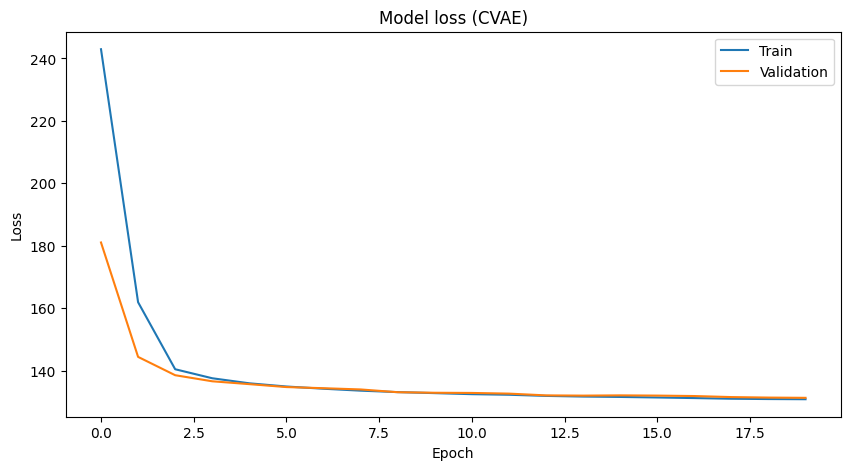

In [43]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(cvae_history.history['loss'])
plt.plot(cvae_history.history['val_loss'])
plt.title('Model loss (CVAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
cvae_latent_reps, _, _ = cvae_encoder.predict([norm_x_train, y_train_cat])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


In [46]:
cvae_latent_mean = np.mean(cvae_latent_reps, axis=0)
cvae_latent_std = np.std(cvae_latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


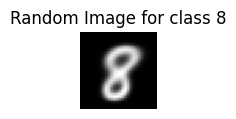

In [92]:
#random_class = np.random.random_integers(np.unique(y_train).min(), np.unique(y_train).max()).item()
random_class = 8
#display(random_class)
cvae_label = np.zeros(shape=(1, cvae_innput_labels_dim))
cvae_label[0, random_class] = 1
cvae_encoded_img = np.random.normal(size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
cvae_decoded_img = cvae_decoder.predict([cvae_encoded_img, cvae_label])
# Genera una nuova immagine
plot_img(cvae_decoded_img[0], titolo=f"Random Image for class {random_class}", figsize=(1,1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


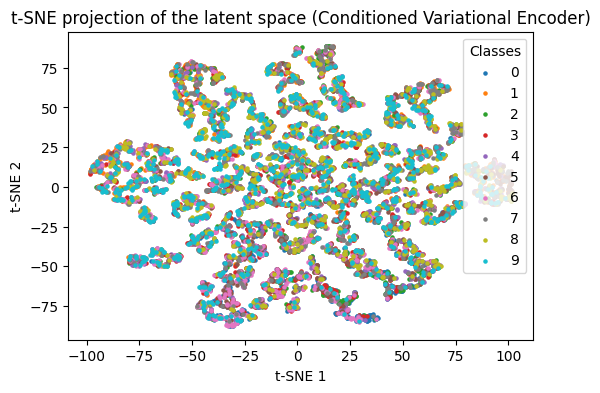

In [93]:
plot_encoding_tsne(cvae_encoder, [norm_x_test, y_test_cat], y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder)")

# Latent Spaces Analysis

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


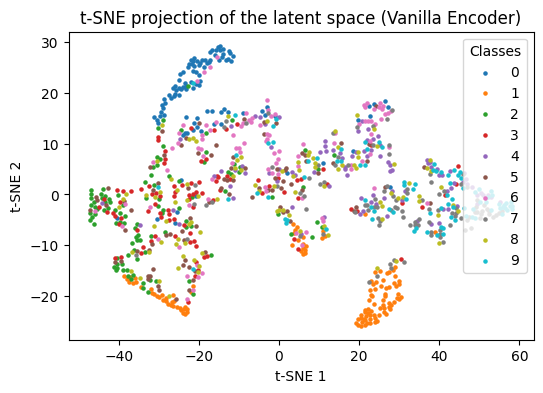

In [94]:
plot_encoding_tsne(vanilla_encoder, flatten_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Vanilla Encoder)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


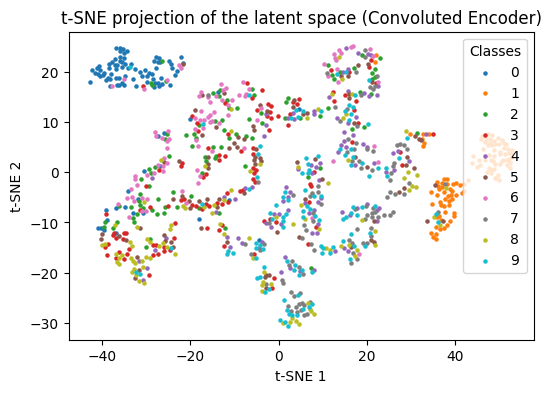

In [95]:
plot_encoding_tsne(conv_encoder, norm_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Convoluted Encoder)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


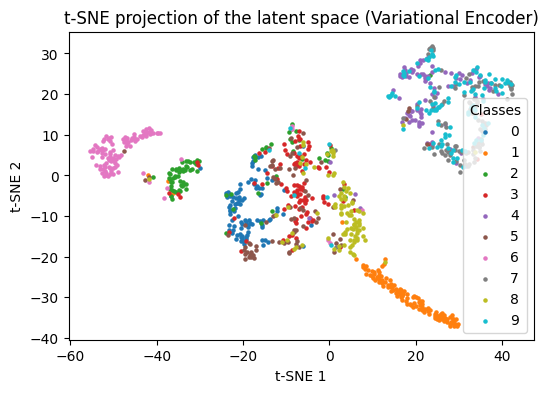

In [96]:
plot_encoding_tsne(vae_encoder, norm_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Variational Encoder)")

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


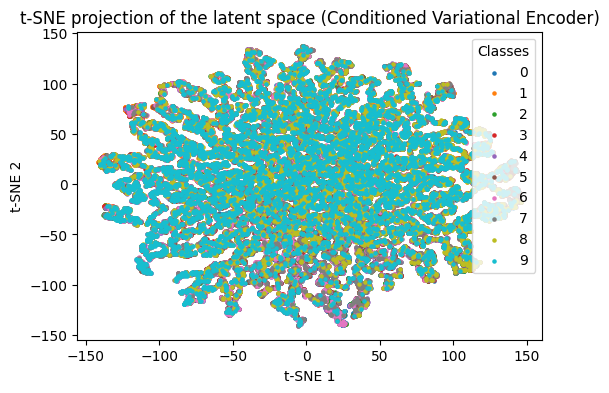

In [97]:
plot_encoding_tsne(cvae_encoder, [norm_x_train, y_train_cat], y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder)")

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


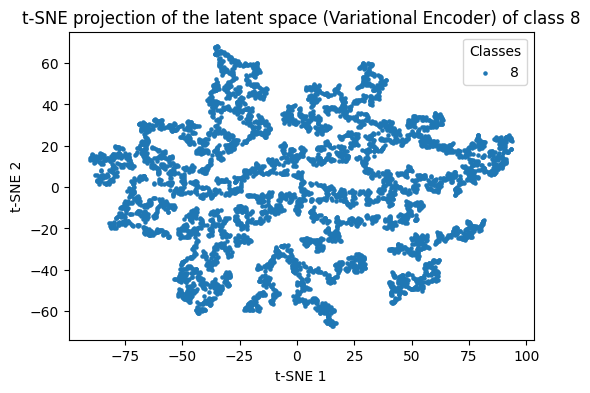

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


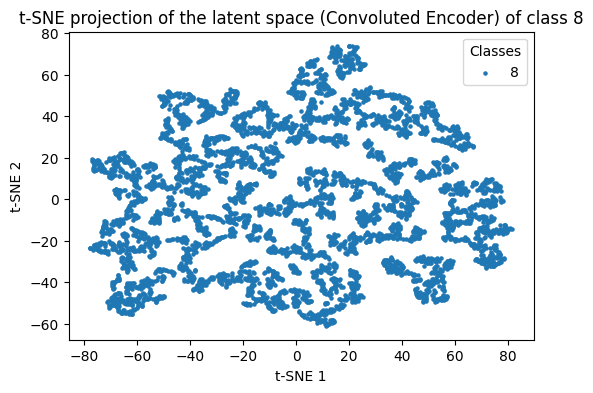

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


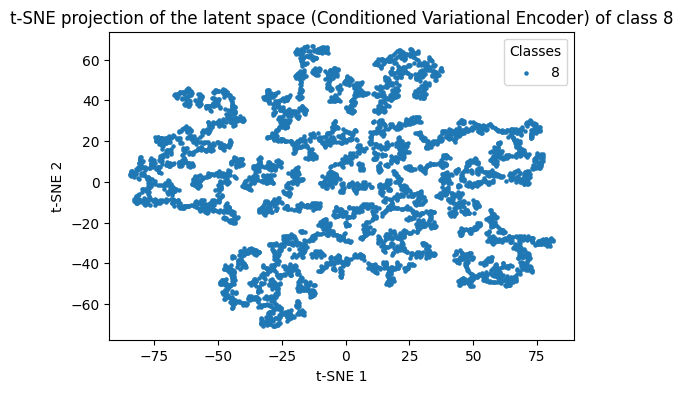

In [98]:
class_to_analyze = 8
indexes_to_analyze = [i for i,x in enumerate(y_train) if x == class_to_analyze]
norm_x_train_to_analyze = norm_x_train[indexes_to_analyze]
y_train_to_analyze = y_train[indexes_to_analyze]
y_train_to_analyze_cat = cvae_model.transform_to_categorical(y_train_to_analyze)

plot_encoding_tsne(vae_encoder, norm_x_train_to_analyze, y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Variational Encoder) of class {class_to_analyze}")
plot_encoding_tsne(conv_encoder, norm_x_train_to_analyze, y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Convoluted Encoder) of class {class_to_analyze}")
plot_encoding_tsne(cvae_encoder, [norm_x_train_to_analyze, y_train_to_analyze_cat], y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder) of class {class_to_analyze}")